<a href="https://colab.research.google.com/github/nikhelll/Finance-Tidbits/blob/main/Algorithmic_Trading_%26_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

In [ ]:
!pip install pyfolio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dtime
import pandas_datareader.data as web
import os
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
start_date = dtime.date(2019,1,2)
end_date = dtime.date(2025,4,30)
stock = 'AAPL'
df = yf.download(stock,start = start_date ,end = end_date )


[*********************100%***********************]  1 of 1 completed


In [11]:
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.994495,148158800,NaN
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.209957,365248800,-0.104925
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.670361,234428400,0.041803


In [12]:
df['ma15'] = df['Adj Close'].rolling(window=15).mean()
df['std'] = df['Adj Close'].rolling(window=15).std()
df['upper_band'] = df['ma15'] + (2 * df['std'])
df['lower_band'] = df['ma15'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(10)

,Close,Adj Close,Volume,bnh_returns,ma15,std,upper_band,lower_band
Date,,,,,,,,
2023-07-07,190.679993,190.679993,46778000,-0.005909,188.399999,3.150030,194.700059,182.099939
2023-07-10,188.610001,188.610001,59922200,-0.010915,188.573333,3.079876,194.733086,182.413580
2023-07-11,188.080002,188.080002,46638100,-0.002814,188.784000,2.915840,194.615681,182.952319
2023-07-12,189.770004,189.770004,60750200,0.008945,189.101334,2.728793,194.558919,183.643748
2023-07-13,190.539993,190.539993,41342300,0.004049,189.539999,2.345184,194.230367,184.849632
2023-07-14,190.690002,190.690002,41573900,0.000787,189.786000,2.251374,194.288748,185.283251
2023-07-17,193.990005,193.990005,50520200,0.017158,190.273334,2.321107,194.915549,185.631119
2023-07-18,193.729996,193.729996,48353800,-0.001341,190.837333,2.027830,194.892994,186.781673
2023-07-19,195.100006,195.100006,80507300,0.007047,191.306667,2.150116,195.606900,187.006434


In [13]:
# BUY condition
df['signal'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

# SELL condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma15,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,,
2023-07-14,190.690002,190.690002,41573900,0.000787,189.786000,2.251374,194.288748,185.283251,0,-1.0,-0.000787
2023-07-17,193.990005,193.990005,50520200,0.017158,190.273334,2.321107,194.915549,185.631119,0,-1.0,-0.017158
2023-07-18,193.729996,193.729996,48353800,-0.001341,190.837333,2.027830,194.892994,186.781673,0,-1.0,0.001341
2023-07-19,195.100006,195.100006,80507300,0.007047,191.306667,2.150116,195.606900,187.006434,0,-1.0,-0.007047
2023-07-20,193.130005,193.130005,58967065,-0.010149,191.565334,2.118171,195.801676,187.328993,0,-1.0,0.010149


Buy and hold returns: 1.6259222714429122
Strategy returns: -0.8532372886227917


<Axes: xlabel='Date'>

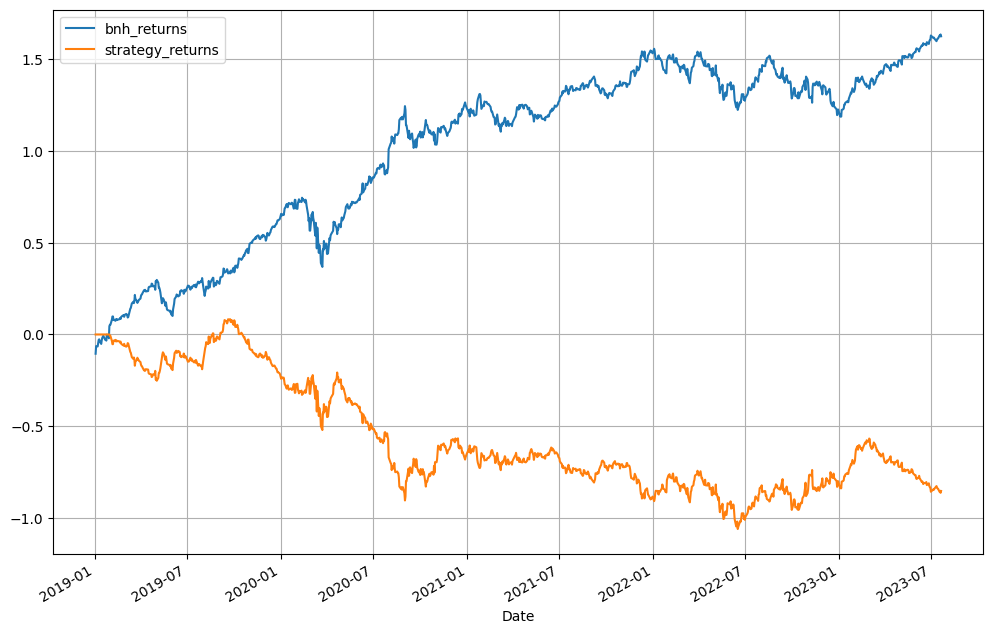

In [14]:
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2015-01-02
End date,2023-04-28
Total months,99
,Backtest
Annual return,-15.6%
Cumulative returns,-75.7%
Annual volatility,29.6%
Sharpe ratio,-0.43
Calmar ratio,-0.18
Stability,0.91
Max drawdown,-86.6%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


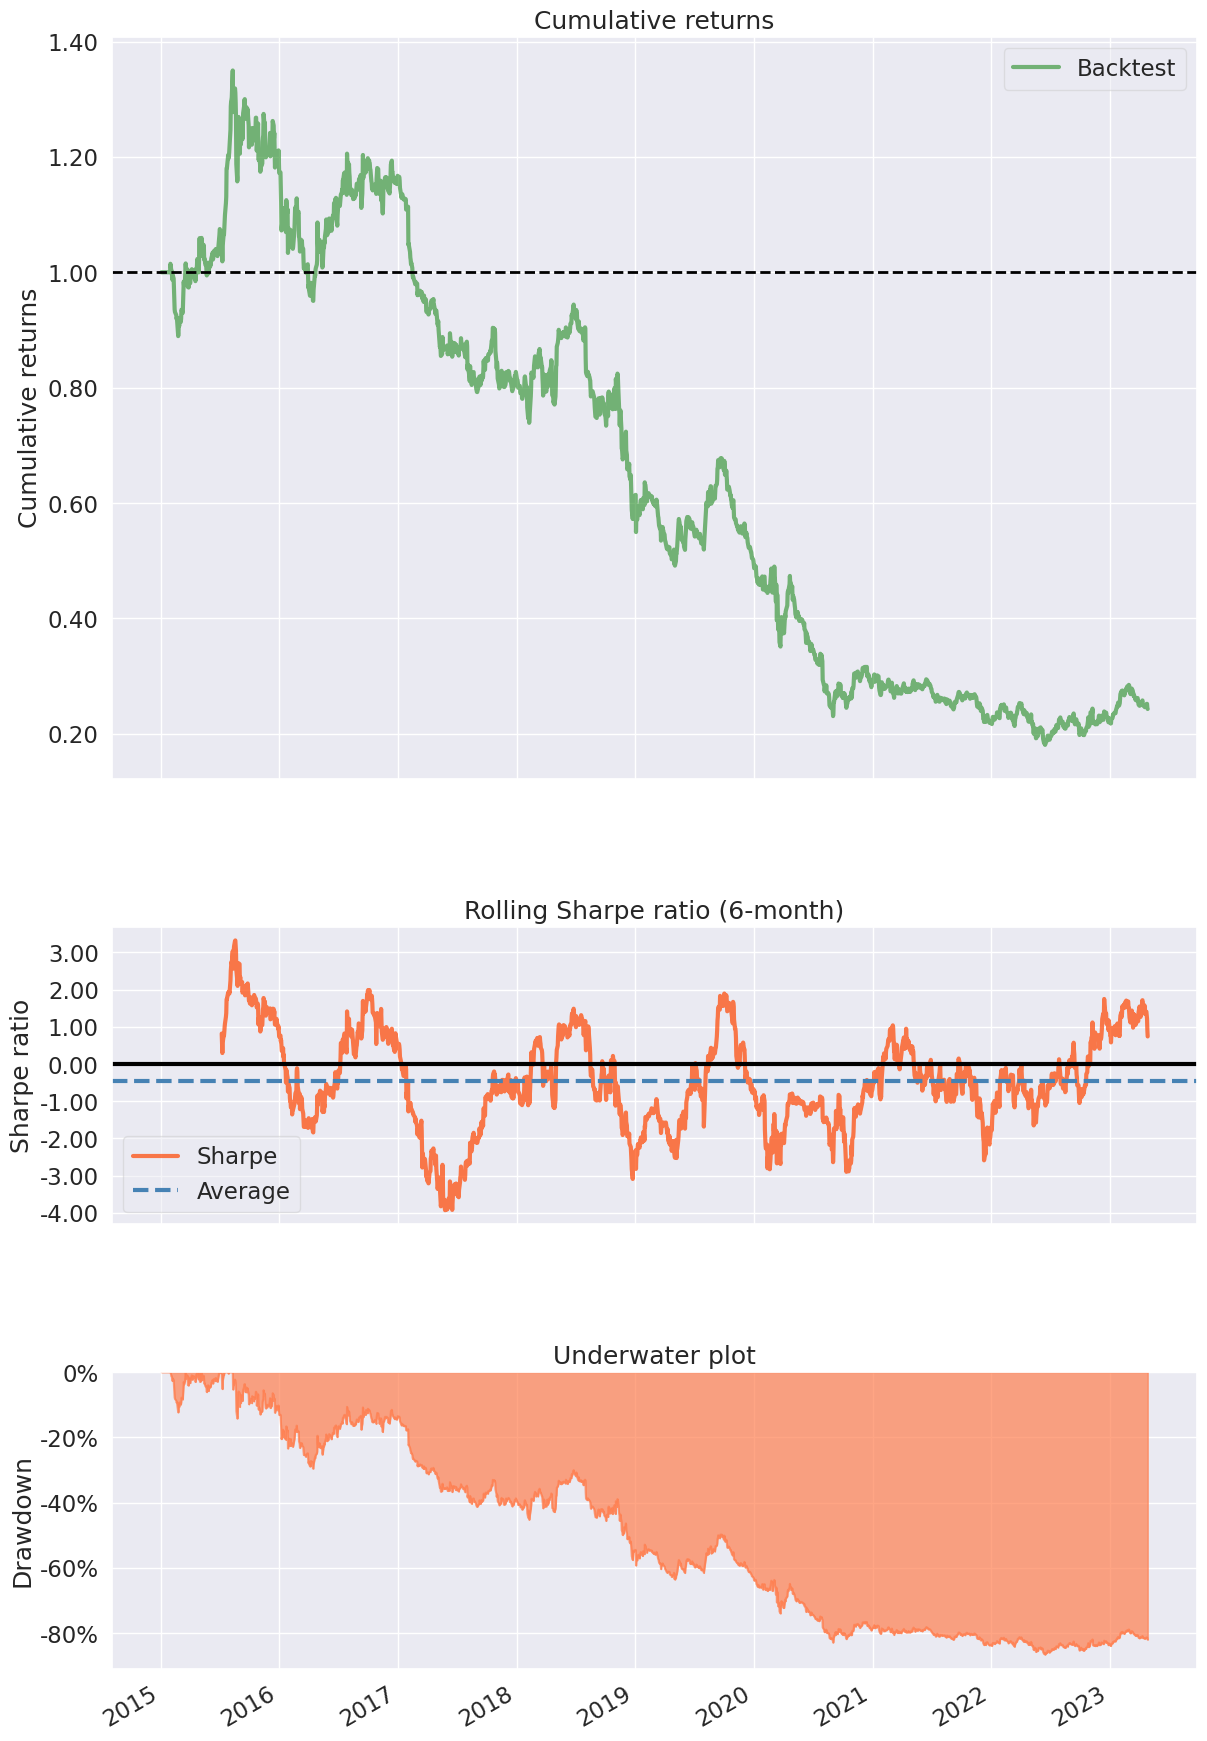

In [27]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())